# Employee Churn Predicter

Hiring employees is a resource intensive process and when the churn rate of employees is high, an organization must hire new employees which is again a resource intensive process.
Current methods of gauging an employee's intent of quitting their job rely on insights from exit interviews which do not paint a generalized
picture of the scenario. 
Our aim is to create a model that can predict whether an employee will leave a company.

## Contents

1. [Importing Libraries & Datasets](#Importing-Libraries-&-Datasets)
2. [Data Pre-processing](#Data-Pre-processing)
3. [Feature Selection](#Feature-Selection)
4. [Hyperparameter tuning-Hyperopt](#Hyperparameter-tuning-Hyperopt)
5. [Model Evaluation](#Model-Evaluation)

### Importing Libraries & Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from mlxtend.feature_selection import SequentialFeatureSelector
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import confusion_matrix

In [2]:
department_data = pd.read_csv('department_data.csv')
employee_details_data = pd.read_csv('employee_details_data.csv')
employee_data = pd.read_csv('employee_data.csv')

### Data Pre-processing

In [3]:
department_data

,dept_id,dept_name,dept_head
0,D00-IT,IT,Henry Adey
1,D00-SS,Sales,Edward J Bayley
2,D00-TP,Temp,Micheal Zachrey
3,D00-ENG,Engineering,Sushant Raghunathan K
4,D00-SP,Support,Amelia Westray
5,D00-FN,Finance,Aanchal J
6,D00-PR,Procurement,Louie Viles
7,D00-AD,Admin,Evelyn Tolson
8,D00-MN,Management,Ellie Trafton
9,D00-MT,Marketing,Reuben Swann


In [4]:
department_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   dept_id    11 non-null     object
 1   dept_name  11 non-null     object
 2   dept_head  11 non-null     object
dtypes: object(3)
memory usage: 396.0+ bytes


In [5]:
employee_details_data.head()

,employee_id,age,gender,marital_status
0,113558,43,Male,Married
1,112256,24,Female,Unmarried
2,112586,22,Female,Unmarried
3,108071,36,Male,Married
4,116915,38,Male,Married


In [6]:
employee_details_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14245 entries, 0 to 14244
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   employee_id     14245 non-null  int64 
 1   age             14245 non-null  int64 
 2   gender          14245 non-null  object
 3   marital_status  14245 non-null  object
dtypes: int64(2), object(2)
memory usage: 445.3+ KB


In [7]:
employee_data.head()

,avg_monthly_hrs,department,filed_complaint,last_evaluation,n_projects,recently_promoted,salary,satisfaction,status,tenure,employee_id
0,246.0,NaN,NaN,0.866838,6,NaN,medium,0.134415,Left,4.0,124467
1,134.0,NaN,NaN,0.555718,2,NaN,low,0.511041,Left,3.0,112210
2,156.0,D00-SS,1.0,0.474082,2,NaN,medium,0.405101,Left,3.0,126150
3,256.0,D00-SP,NaN,0.961360,6,NaN,low,0.152974,Left,4.0,125346
4,146.0,D00-SS,NaN,0.507349,2,NaN,medium,0.434845,Left,3.0,113707


In [8]:
employee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14150 entries, 0 to 14149
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14150 non-null  float64
 1   department         13443 non-null  object 
 2   filed_complaint    2046 non-null   float64
 3   last_evaluation    12663 non-null  float64
 4   n_projects         14150 non-null  int64  
 5   recently_promoted  297 non-null    float64
 6   salary             14150 non-null  object 
 7   satisfaction       14000 non-null  float64
 8   status             14150 non-null  object 
 9   tenure             14000 non-null  float64
 10  employee_id        14150 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 1.2+ MB


Since this dataframe contains the most null values, lets start with cleaning this dataframe first

In [9]:
employee_data['department'].value_counts()

department
D00-SS     3905
D00-ENG    2575
D00-SP     2113
D00-IT     1157
D00-PD      855
D00-MT      815
D00-FN      725
D00-MN      593
-IT         207
D00-AD      175
D00-PR      173
D00-TP      150
Name: count, dtype: int64

In [10]:
department_data['dept_id']

0      D00-IT
1      D00-SS
2      D00-TP
3     D00-ENG
4      D00-SP
5      D00-FN
6      D00-PR
7      D00-AD
8      D00-MN
9      D00-MT
10     D00-PD
Name: dept_id, dtype: object

In [11]:
# Replacing -IT with D00-IT
employee_data['department'].replace('-IT','D00-IT', inplace = True)

C:\Users\Admin\AppData\Local\Temp\ipykernel_23596\1177539403.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  employee_data['department'].replace('-IT','D00-IT', inplace = True)


- Department column has 707 missing values. Drop these rows
- Filed complaints have 1 for yes and NaN for no. Change Nan to 0
- Last_evaluation column has 1487 values. Drop these rows
- Recently_promoted column has 1 for yes and NaN for no. Change Nan to 0
- Satisfaction and tenure columns have 150 missing values. Drop these rows

In [12]:
# Executing point 2 & 4
employee_data['filed_complaint'] = employee_data['filed_complaint'].fillna(0)
employee_data['recently_promoted'] = employee_data['recently_promoted'].fillna(0)

In [13]:
employee_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14150 entries, 0 to 14149
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   avg_monthly_hrs    14150 non-null  float64
 1   department         13443 non-null  object 
 2   filed_complaint    14150 non-null  float64
 3   last_evaluation    12663 non-null  float64
 4   n_projects         14150 non-null  int64  
 5   recently_promoted  14150 non-null  float64
 6   salary             14150 non-null  object 
 7   satisfaction       14000 non-null  float64
 8   status             14150 non-null  object 
 9   tenure             14000 non-null  float64
 10  employee_id        14150 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 1.2+ MB


<Axes: >

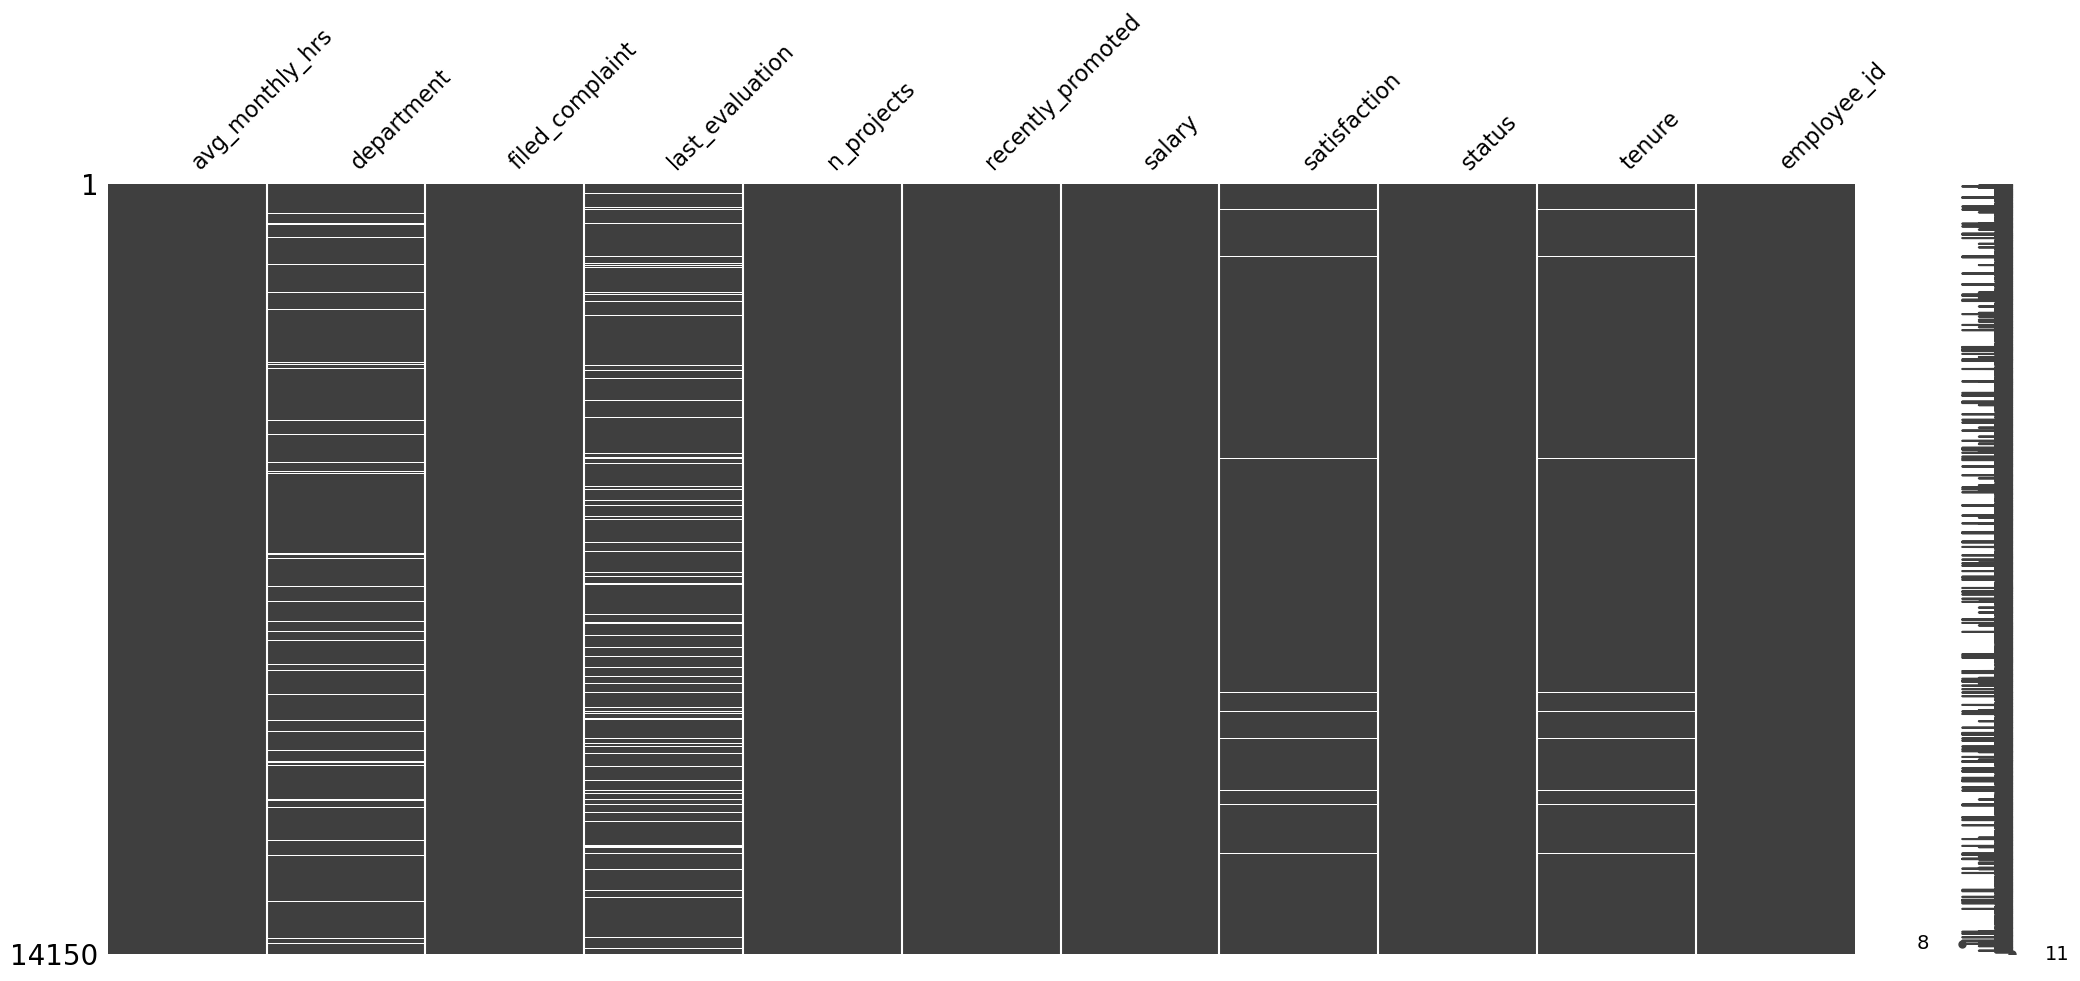

In [14]:
# Visualizing missing values
msno.matrix(employee_data)

In [15]:
employee_data.describe()

,avg_monthly_hrs,filed_complaint,last_evaluation,n_projects,recently_promoted,satisfaction,tenure,employee_id
count,14150.000000,14150.000000,12663.000000,14150.000000,14150.000000,14000.000000,14000.000000,14150.000000
mean,199.994346,0.144594,0.718399,3.778304,0.020989,0.621212,3.499357,112080.750247
std,50.833697,0.351703,0.173108,1.250162,0.143354,0.250482,1.462584,8748.202856
min,49.000000,0.000000,0.316175,1.000000,0.000000,0.040058,2.000000,0.000000
25%,155.000000,0.000000,0.563711,3.000000,0.000000,0.450356,3.000000,105772.500000
50%,199.000000,0.000000,0.724731,4.000000,0.000000,0.652394,3.000000,111291.500000
75%,245.000000,0.000000,0.871409,5.000000,0.000000,0.824925,4.000000,116650.750000
max,310.000000,1.000000,1.000000,7.000000,1.000000,1.000000,10.000000,148988.000000


In [16]:
# Dropping all the null values in department data.
employee_data.dropna(inplace = True)

<Axes: >

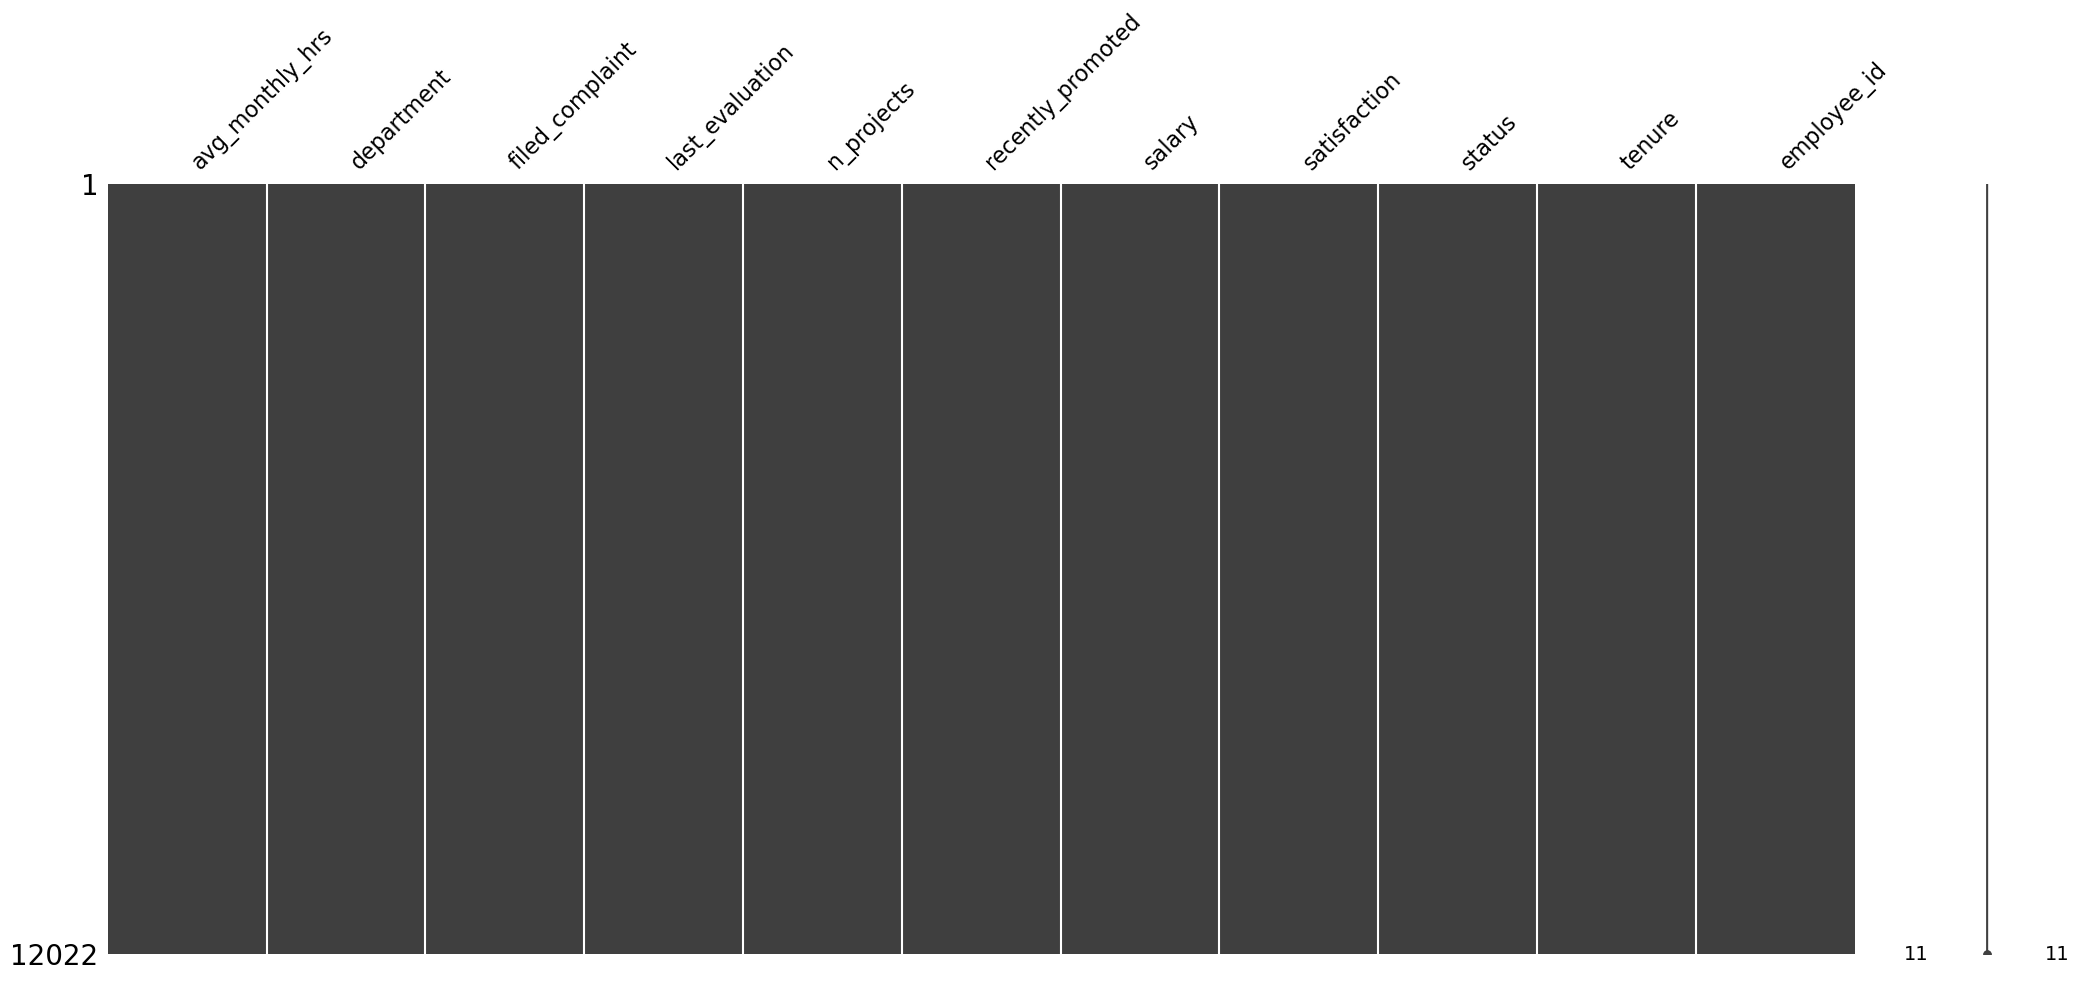

In [17]:
msno.matrix(employee_data) 

In [18]:
employee_details_data

,employee_id,age,gender,marital_status
0,113558,43,Male,Married
1,112256,24,Female,Unmarried
2,112586,22,Female,Unmarried
3,108071,36,Male,Married
4,116915,38,Male,Married
...,...,...,...,...
14240,111781,26,Male,Unmarried
14241,100372,35,Male,Married
14242,128083,30,Female,Married
14243,118487,24,Male,Unmarried


In [19]:
# Merging both the datasets
merged_df = pd.merge(employee_details_data, employee_data, left_on = 'employee_id', right_on='employee_id')
merged_df.drop(columns = ['employee_id'], inplace = True)

<Axes: >

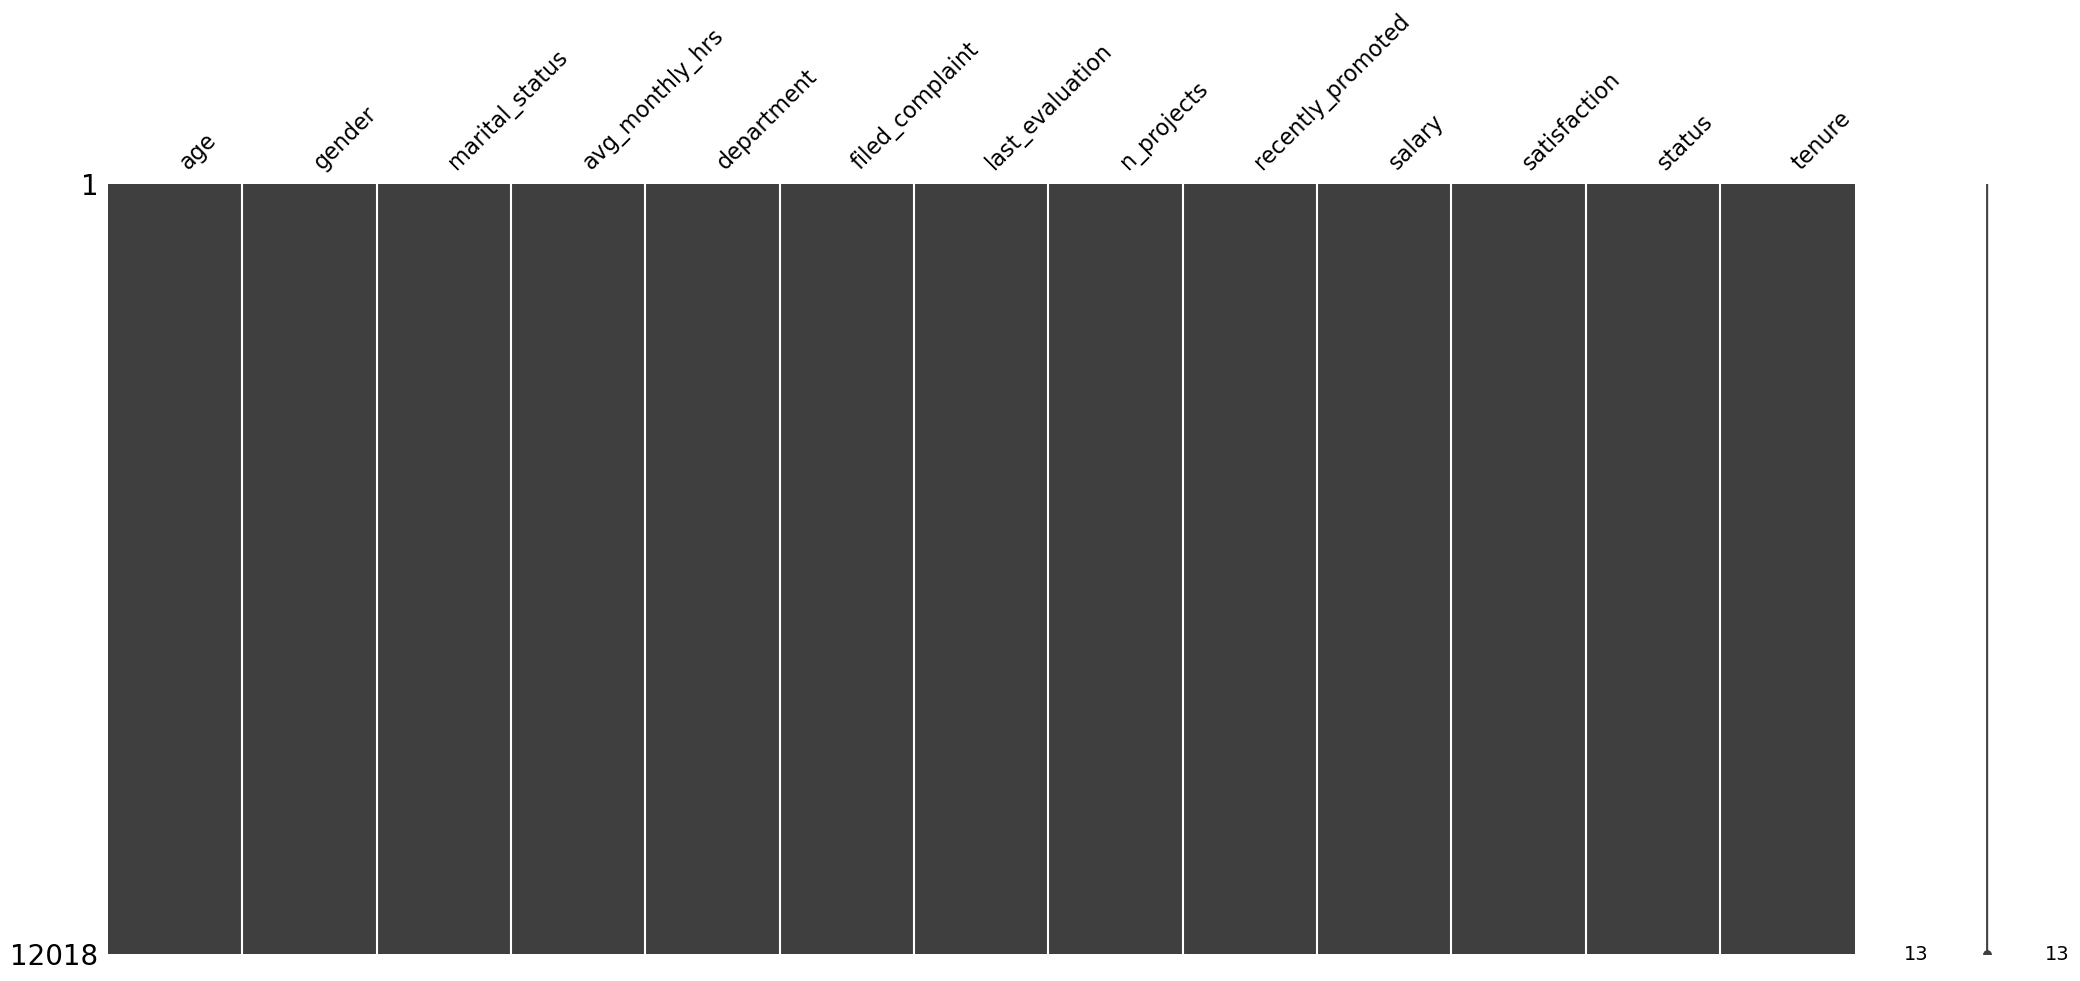

In [20]:
msno.matrix(merged_df)

# EDA
Let's explore the dataset

Text(0, 0.5, 'Average Monthly Hours')

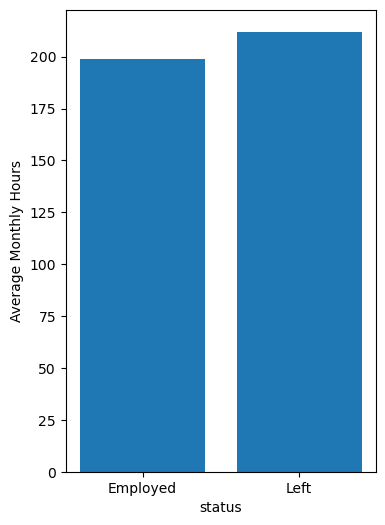

In [21]:
data = merged_df
# Lets check for avg_monthly_hrs against status
a = data.groupby('status')['avg_monthly_hrs'].mean().index
b = data.groupby('status')['avg_monthly_hrs'].mean().values
plt.figure(figsize=(4, 6))
plt.bar(a, b)
plt.xlabel('status')
plt.ylabel('Average Monthly Hours')

The Average monthly hours for employees who leave is slightly higher than for those who are employeed.

In [22]:
data.groupby('status')['avg_monthly_hrs'].mean()

status
Employed    199.090999
Left        211.995904
Name: avg_monthly_hrs, dtype: float64

Text(0, 0.5, 'Number of employees')

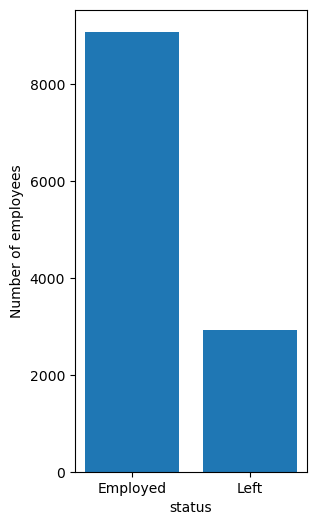

In [23]:
# Lets see the counts of Employeed vs Left

a = data['status'].value_counts().index
b = data['status'].value_counts()
plt.figure(figsize=(3, 6))
plt.bar(a, b)
plt.xlabel('status')
plt.ylabel('Number of employees')

<Axes: xlabel='tenure', ylabel='status'>

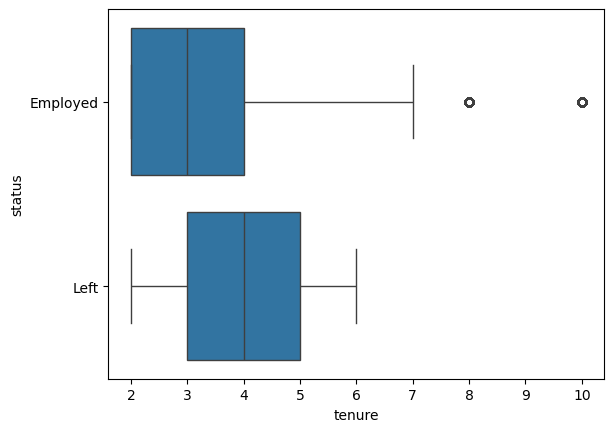

In [24]:
sns.boxplot(data=data, x="tenure", y="status")

Let's check for satisfaction levels for those who were employed vs those who left

Text(0, 0.5, 'Satisfaction')

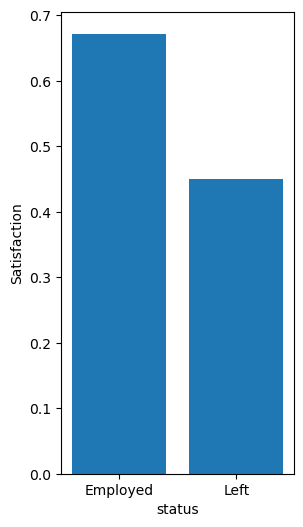

In [25]:
a = data.groupby('status')['satisfaction'].mean().index
b = data.groupby('status')['satisfaction'].mean().values
plt.figure(figsize=(3, 6))
plt.bar(a, b)
plt.xlabel('status')
plt.ylabel('Satisfaction')

This is a clear and logical indicator for employee iteration. Employees who left are generally less satisfied are more likely to leave.

Lets see if it iteration has any relationship with promotion

Text(0, 0.5, 'recently_promoted')

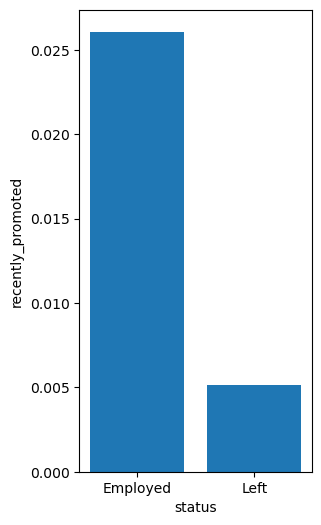

In [26]:
a = data.groupby('status')['recently_promoted'].mean().index
b = data.groupby('status')['recently_promoted'].mean().values
plt.figure(figsize=(3, 6))
plt.bar(a, b)
plt.xlabel('status')
plt.ylabel('recently_promoted')

It appears that 2.6 percent of the employed are promoted. That number is 0.53 percent of those who left. Thus, it can be said that those who are likely to leave have a less promotion rate than thoe who are employed

<Axes: >

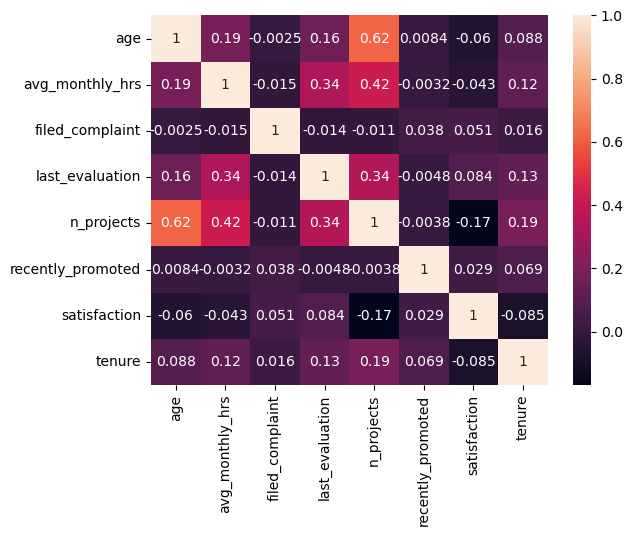

In [27]:
# Finally , lets plot a correlation chart
sns.heatmap(data.select_dtypes(include = 'number').corr(), annot = True)

Insights from the above chart:
- N_projects and age have a strong correlation which is understandable since as age increases, the number of projects worked on also increases
- N_projects and avg_monthly_hrs have a mild corellation of 0.44
- Avg_monthly_hrs also has a slight correlation with last_evaluation, suggesting that longer working hours indicate slightly better chances of a good evaluation

## Feature Selection

In [28]:
X = merged_df.drop('status', axis = 1)
y = merged_df['status']
encoded_df = pd.get_dummies(X, columns = ['salary','gender','marital_status','department'], drop_first=True)
# Getting dummies for catagorical variables

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
model = XGBClassifier(random_state=3)

y_pred = cross_val_predict(model, encoded_df, y, cv=10)

accuracy = accuracy_score(y, y_pred)
print('accuracy: ', accuracy)
precision = precision_score(y, y_pred)
print("precision:  ", precision)
recall = recall_score(y, y_pred)
print("Recall:  ", recall)
f1 = f1_score(y, y_pred)
print("f1:  ", f1)

accuracy:  0.9772008653686137
precision:   0.967605633802817
Recall:   0.9378839590443686
f1:   0.9525129982668977


Now lets try A feature selection technique called SequentialFeatureSelector

In [29]:
model = XGBClassifier(random_state=3)

back_selector = SequentialFeatureSelector(model,k_features = (10), forward = False, floating = False, verbose = 0, cv = 4, scoring = 'f1_macro').fit(encoded_df, y)
back_selector.k_feature_names_

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is deprecated and will be removed in version 1.6. Pass parameters via `params` instead.
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:73: FutureWarning: `fit_params` is depreca

('avg_monthly_hrs',
 'filed_complaint',
 'last_evaluation',
 'n_projects',
 'satisfaction',
 'tenure',
 'salary_medium',
 'marital_status_Unmarried',
 'department_D00-SP',
 'department_D00-SS')

In [30]:
# Feature importances given by the classifier
model = XGBClassifier(random_state=3)
model.fit(encoded_df, y)
pd.DataFrame({'feature': encoded_df.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending = False)

,feature,importance
7,tenure,0.243128
4,n_projects,0.162127
6,satisfaction,0.151873
1,avg_monthly_hrs,0.063081
3,last_evaluation,0.060778
2,filed_complaint,0.057116
11,marital_status_Unmarried,0.044543
8,salary_low,0.022800
10,gender_Male,0.021841
14,department_D00-IT,0.021568


In [31]:
# Making the 1st dataset
encoded_df_1 = pd.get_dummies(merged_df, columns = ['salary','gender','marital_status','department'], drop_first=True)
y1 = encoded_df_1['status'].values
X1 = encoded_df_1[['age','avg_monthly_hrs','last_evaluation','n_projects','satisfaction','tenure','salary_low','salary_medium','gender_Male','marital_status_Unmarried']]
label_encoder = LabelEncoder()
y1 = label_encoder.fit_transform(y1)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=3)

In [32]:
# Making the 2nd dataset
encoded_df_2 = pd.get_dummies(merged_df, columns = ['salary','gender','marital_status','department'], drop_first=True)
X2 = encoded_df_2[list(back_selector.k_feature_names_)]
y2 = y1
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state = 3)

Now that we have both the datasets, we shall run hyperopt to train train the model parameters

## Hyperparameter tuning-Hyperopt

Hyperopt is a library used to find the best set of hyperparameters for a machine learning algorithm. It uses Bayesian optimization for tuning the model hyperparameters

In [33]:
# Hyperopt objective function
def objective(params):
    
    clf = XGBClassifier(
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=2  # Set a random state for reproducibility
    )

    cv_scores = cross_val_score(clf, X1_train, y1_train, cv=5, scoring = make_scorer(f1_score))
    avg_f1 = np.mean(cv_scores)
    return {'loss': -avg_f1, 'status': STATUS_OK}

space = {
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.005 , 0.3),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'min_child_weight': hp.choice('min_child_weight', [2, 3, 5, 7, 9]),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1)
}

trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best_param " , best)

best_params = {
    'n_estimators': 1000,
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'gamma': best['gamma'],
    'min_child_weight': best['min_child_weight'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree']
}

final_model = XGBClassifier(**best_params, random_state = 2)
final_model.fit(X1_train, y1_train)
final_preds = final_model.predict(X1_test)

print("Recall:", recall_score(y1_test, final_preds))
print("F1 Score:", f1_score(y1_test, final_preds))

100%|██████████| 100/100 [01:36<00:00,  1.04trial/s, best loss: -0.948918610023398]
Best_param  {'colsample_bytree': 0.9984031818923914, 'gamma': 0.15018573369095123, 'learning_rate': 0.2426703842870301, 'max_depth': 9.0, 'min_child_weight': 0, 'subsample': 0.9402401536003892}
Recall: 0.9404186795491143
F1 Score: 0.9589490968801314


This score is above what we had initially observed. Thus removing data set 1 did not prove to be the best feature set. Now lets try data set 2

In [34]:
def objective(params):

    clf = XGBClassifier(
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state = 2 
    )
    cv_scores = cross_val_score(clf, X2_train, y2_train, cv=5, scoring = make_scorer(f1_score))
    avg_f1 = np.mean(cv_scores)
    
    return {'loss': -avg_f1, 'status': STATUS_OK}


space = {
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.005 , 0.3),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'min_child_weight': hp.choice('min_child_weight', [2, 3, 5, 7, 9]),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1)
}

trials = Trials()
best = fmin(fn=objective,
            space=space, 
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best parameters found: ", best)

best_params2 = {
    'n_estimators': 1000,
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'gamma': best['gamma'],
    'min_child_weight': best['min_child_weight'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree']
}

model = XGBClassifier(**best_params2, random_state = 48)
model.fit(X2_train, y2_train)
y_preds = model.predict(X2_test)
 
print("Recall:", recall_score(y2_test, y_preds))
print("F1 Score:", f1_score(y2_test, y_preds))

100%|██████████| 100/100 [01:34<00:00,  1.05trial/s, best loss: -0.951243766725411]
Best parameters found:  {'colsample_bytree': 0.8808375110751188, 'gamma': 0.4174245320809568, 'learning_rate': 0.1911314169711876, 'max_depth': 12.0, 'min_child_weight': 0, 'subsample': 0.9143749196616732}
Recall: 0.9420289855072463
F1 Score: 0.9629629629629629


## Model Evaluation

In [35]:
X = merged_df.drop('status', axis = 1)
y = merged_df['status']
encoded_df = pd.get_dummies(X, columns = ['salary','gender','marital_status','department'], drop_first=True)
# Getting dummies for catagorical variables

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
model1 = XGBClassifier(**best_params, random_state=3)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

cv_scores = cross_validate(model, encoded_df, y, cv=10, scoring=scoring)

print("Accuracy1: ", cv_scores['test_accuracy'].mean())
print("Precision1: ", cv_scores['test_precision'].mean())
print("Recall1: ", cv_scores['test_recall'].mean())
print("F1 Score1: ", cv_scores['test_f1'].mean())


model2 = XGBClassifier(**best_params2, random_state=3)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

cv_scores2 = cross_validate(model2, encoded_df, y, cv=12, scoring=scoring)

print("Accuracy2: ", cv_scores2['test_accuracy'].mean())
print("Precision2: ", cv_scores2['test_precision'].mean())
print("Recall2: ", cv_scores2['test_recall'].mean())
print("F1 Score2: ", cv_scores2['test_f1'].mean())

Accuracy1:  0.9800302299387228
Precision1:  0.9797422177791925
Recall1:  0.937542662116041
F1 Score1:  0.9581231914337767
Accuracy2:  0.9799470323422419
Precision2:  0.9780333566189969
Recall2:  0.9389023642243783
F1 Score2:  0.9580355328145966


Both the datasets give a decent f1 score and recall score for the model. A high recall value indicates that most of the candidates who are likely to leave will be predicted accurately by the model

## Adjusting The Threshold
Now let's try to adjust the threshold that classifies an instance as a 1 or 0. 
We shall reduce the threshold below 0.5 and try to find a conducive threshold that gives maximum recall and f1 score

In [36]:
model = XGBClassifier(**best_params2, random_state = 3)

model.fit(X1_train, y1_train)

y_prob = model.predict_proba(X1_test)[:, 1]

# Setting a threshold
threshold = 0.1
y_pred_custom = (y_prob >= threshold).astype(int)

print('accuracy: ', accuracy_score(y1_test, y_pred_custom))

precision = precision_score(y1_test, y_pred_custom)
print("precision:  ", precision)

recall = recall_score(y1_test, y_pred_custom)
print("Recall:  ", recall)

f1 = f1_score(y1_test, y_pred_custom)
print("f1:  ", f1)

accuracy:  0.9696339434276207
precision:   0.9228395061728395
Recall:   0.9629629629629629
f1:   0.9424743892829


Lets check the false positive rate

In [37]:
# Let's check the false positve rate
tn, fp, fn, tp = confusion_matrix(y1_test, y_pred_custom).ravel()
fpr = fp / (fp + tn)
print("False Positive Rate: ", fpr)

False Positive Rate:  0.028042624789680313




Thus by feature selection, hyperparameter tuning and threshold adjustment, we were able to create a model that can efficiently predict whether or not an employee is likely to leave the company